In [2]:
import pandas as pd
import os
os.chdir('/Users/markjos/projects/malachor5')
import numpy as np
from typing import Literal
from tqdm import tqdm
from glob import glob
import math
from string import punctuation

import sys
sys.path.append('scripts')
from eval import get_word_language

In [3]:
longform_csv_path = 'data/elicitation-wavs/autotranscribed/metadata.csv'
df = pd.read_csv(longform_csv_path, index_col=0, keep_default_na=False)
print(f"{df.shape=}")
df.head()

df.shape=(109393, 8)


,wav_path,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred
0,,asr,30,1414,"Hello, hello, hello.",/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG
1,,asr,2106,4755,"Hello, hello, hello, hello, hello.",/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG
2,,asr,6240,8502,"Hello, hello. This shit.",/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG
3,,asr,8535,8569,...,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG
4,,asr,8721,11269,Hello. Hello. Hello.,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG


# Whisper output cleaning
Figure out what labels are excessive repetitions and exclude

In [4]:
df['charlen'] = df['transcription'].str.len()
df['charlen']

0      21
1      35
2      25
3       4
4      21
       ..
767     6
768     6
769    43
770     6
771    34
Name: charlen, Length: 109393, dtype: int64

In [5]:
def entropy(string):
    """Calculates the Shannon entropy of a string."""

    # Get the probability of each character in the string
    prob = {}
    for c in string:
        if c not in prob:
            prob[c] = 0
        prob[c] += 1
    for c in prob:
        prob[c] /= len(string)

    # Calculate the entropy
    entropy = -sum(p * math.log2(p) for p in prob.values())

    return entropy
df['entropy']=df['transcription'].apply(entropy)
df['entropy'].describe()

count    109393.000000
mean          3.253243
std           0.778939
min           0.000000
25%           2.750000
50%           3.471354
75%           3.822381
max           4.731241
Name: entropy, dtype: float64

<Axes: >

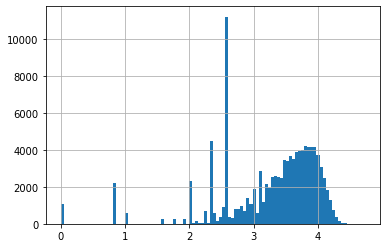

In [6]:
df['entropy'].hist(bins=100)

In [7]:
df['duration']=df['end']-df['start']
df[['duration', 'charlen', 'entropy']].corr()

,duration,charlen,entropy
duration,1.000000,0.030885,0.495035
charlen,0.030885,1.000000,0.134147
entropy,0.495035,0.134147,1.000000


In [8]:
df.loc[df['entropy']<2, 'transcription'].unique()

array([' ...', ' Uh...', '', ' So...',
       ' W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. W. B by a i i a i           ',
       ' Mmm.', ' Hmm.', ' Doo doo doo doo.', ' See?', ' do do do.', ' .',
       ' m.', ' Mmm. Mm. Mm. Mm.',
       ' do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do d

In [9]:
df['charlen_nmzd'] = df['charlen'] / df['charlen'].max()
df['entropy_nmzd'] = df['entropy'] / df['entropy'].max()
df['entropy_over_charlen'] = df['entropy_nmzd'] / df['charlen_nmzd']
df['entropy_over_charlen'].describe()

count    108297.000000
mean        126.277742
std          90.754525
min           0.014070
25%          55.380138
50%          96.546911
75%         186.139142
max         336.562651
Name: entropy_over_charlen, dtype: float64

In [10]:
df.sort_values('entropy_over_charlen', ascending=True).iloc[3_566:3_570]['transcription'].to_list()

[" The question is like how does a like it hold you versus you pulled it right? What forms do you get for you when you have hit the sheep as the subject, the object and similarly for they, the sheep as subjects versus objects, do you get the low or them for the sheep, right? So you've read them, are you getting some lows showing up at the end when you have a sheep, for now, object. Yes, and I think we were partly swayed by Rari when we were creating these. It's that Rari doesn't make those human distinctions that Moro does and Tera seems to.",
 " I have just general syntax questions that are sort of burning for me that I would like to get. So for example, that transitive. And then like different object forms for different arguments that transitive. And then also I'm curious about predominant adjuncts. Like I did it that way or I went there or things like that to see if those also get phenomenalized and promoted to subject position, or in it, or under it, things like that. To see if tho

In [11]:
cutoff_idx = 3_566
df_sorted=df.sort_values('entropy_over_charlen', ascending=True)
df_cutoff=df_sorted.iloc[cutoff_idx:]
df_cutoff.sort_values('charlen', ascending=False).head()['transcription'].to_list()

[" The question is like how does a like it hold you versus you pulled it right? What forms do you get for you when you have hit the sheep as the subject, the object and similarly for they, the sheep as subjects versus objects, do you get the low or them for the sheep, right? So you've read them, are you getting some lows showing up at the end when you have a sheep, for now, object. Yes, and I think we were partly swayed by Rari when we were creating these. It's that Rari doesn't make those human distinctions that Moro does and Tera seems to.",
 " I have just general syntax questions that are sort of burning for me that I would like to get. So for example, that transitive. And then like different object forms for different arguments that transitive. And then also I'm curious about predominant adjuncts. Like I did it that way or I went there or things like that to see if those also get phenomenalized and promoted to subject position, or in it, or under it, things like that. To see if tho

In [12]:
df_cutoff[['duration', 'charlen', 'entropy']].corr()

,duration,charlen,entropy
duration,1.000000,0.814998,0.514534
charlen,0.814998,1.000000,0.624448
entropy,0.514534,0.624448,1.000000


In [13]:
str_is_punct = lambda s: all(c in punctuation for c in s)
is_punct = df_cutoff['transcription'].str.strip().apply(str_is_punct)
df_cutoff[is_punct].shape

(3877, 14)

In [14]:
df_valid = df_cutoff[~is_punct].copy()
df_valid.shape[0], df.shape[0], df_valid.shape[0] / df.shape[0]

(101950, 109393, 0.9319609115756949)

In [15]:
df.sort_values('entropy_over_charlen').to_csv('data/elicitation-wavs/autotranscribed/metadata_sorted_by_entropy.csv', index=False)

In [16]:
df[df['sli_pred']=='TIC']

,wav_path,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred,charlen,entropy,duration,charlen_nmzd,entropy_nmzd,entropy_over_charlen
213,,asr,902522,907804,àprí və́lɛ̀ðɛ̀ və́lɛ̀ðɛ̀ jàvə́lɛ̀ðɛ̀,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,39,3.406320,5282,0.012940,0.719963,55.640241
402,,asr,1649663,1652329,ðà ɔ́ɟɔ́ və́lɛ̀ðɛ̀ ùnɛ́ɾɛ̀,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,28,3.508622,2666,0.009290,0.741586,79.826430
451,,asr,1807782,1809250,nd̪ɔ̀bàgɛ̀,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,11,3.027169,1468,0.003650,0.639826,175.312217
461,,asr,1858373,1859352,nd̪ɔ̀bàgɛ̀,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,11,3.027169,979,0.003650,0.639826,175.312217
476,,asr,1920844,1922802,án ɔ́ɟɔ́ kávə̀lɛ̀ðɔ́ nd̪ɔ̀bàgɛ̀,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,34,3.771902,1958,0.011281,0.797233,70.672379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,,asr,2278257,2280822,àń ndɔ́n káɾògɛ́ àprí ðɔ̀ndɔ̀ðɔ̀ ídɔ̀t̪...,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,62,3.936188,2565,0.020571,0.831957,40.443836
528,,asr,2331059,2332358,làgɛ́ðà ǹdɔ̀dɔ̀ t̪ɛ̀lúbú,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,29,3.676441,1299,0.009622,0.777056,80.760273
567,,asr,2469434,2470682,ðɛ̀bùltì,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,10,2.846439,1248,0.003318,0.601626,181.330190
575,,asr,2498762,2500804,ðə́və̀ɽá ðɛ́r ívè,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,20,3.421928,2042,0.006636,0.723262,108.995625


In [17]:
asr_csv_path = 'data/hf-datasets/tira-clean/metadata.csv'
asr_df = pd.read_csv(asr_csv_path, index_col=0, keep_default_na=False)
asr_df=asr_df.reset_index(names='asr_index')
asr_df['tier_name']='human_label'
asr_df['eaf_path']=asr_df['eaf_source']
asr_df['sli_pred']=np.nan

df_valid['asr_index']=np.nan
df_valid['split']=np.nan

merge_cols = [
    'tier_name', 'start', 'end',
    'transcription', 'eaf_path',
    'wav_source', 'sli_pred',
    'asr_index', 'split',
]

merged_df = pd.concat([df_valid[merge_cols], asr_df[merge_cols]], ignore_index=True)
print(merged_df.shape)
merged_df.head()

(122430, 9)


,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred,asr_index,split
0,asr,1452833.0,1488490.0,The question is like how does a like it hold ...,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN
1,asr,767691.0,805812.0,I have just general syntax questions that are...,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN
2,asr,3186520.0,3214954.0,"Yeah. And Peter and I have worked on, I mean,...",/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN
3,asr,3130967.0,3134697.0,Yes. Do you guys hear schwa? Or do you hear a...,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN
4,asr,2108055.0,2136304.0,"You know, the timer's off now, right? We can ...",/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN


In [18]:
merged_df[merged_df['tier_name']=='human_label']

,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred,asr_index,split
101950,human_label,2497647.0,2498747.0,lə̀və̀lɛ̀ðɛ́l únɛ̀ɾɛ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,0.0,train
101951,human_label,2325216.0,2326306.0,kə̀ŋàcîí,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,1.0,test
101952,human_label,354974.0,356382.0,ŋ̀gátɛ́və́lɛ̂ðɔ́ nd̪ɔ̀bàgɛ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,2.0,train
101953,human_label,154905.0,157215.0,ŋɔ́ðɔ́ ŋá və́lɛ̀ðà ðàŋàlà nd̪ɔ̀bà,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,3.0,train
101954,human_label,2311065.0,2312385.0,ðə̀və̀lèðɔ̀ŋ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,4.0,train
...,...,...,...,...,...,...,...,...,...
122425,human_label,1005320.0,1007400.0,ðá nɛ́lê və̀lɛ̀ðɔ́ nd̪ɔ̀bà,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,20475.0,train
122426,human_label,997005.0,997694.0,ŋə̀vrà,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,20476.0,test
122427,human_label,1121405.0,1122391.0,ŋə̀búrŋɛ̀ ánó,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,20477.0,train
122428,human_label,1050093.0,1051320.0,lá vŕðìt̪ɔ̀ kukuŋu ðɛdɔɽɔ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,20478.0,train


In [19]:
merged_df['filestem']=merged_df['eaf_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
merged_df['filestem']

0           HH02192021
1           HH20210707
2           HH06112021
3           HH20211004
4           HH20210623
              ...     
122425      HH20230516
122426    HH08212020-2
122427      HH20230626
122428      HH20240308
122429      HH20210707
Name: filestem, Length: 122430, dtype: object

# Group annotations
- For each recording
  - Sort labels by start time
  - For each human label in recording
    - Assign rows to the label by associating preceding or following machine labels to the human label
    - Associate rows by setting the `asr_index` col for each machine label to the matching human label
    - Stop when adding another label would make the label >30s or when another `in_dataset` or `human_label` row is reached
    - Whenever a label is added, set the column for `in_dataset` to True
- Write a function to 

In [20]:
def associate_machine_labels(df: pd.DataFrame):
        df=df.sort_values('start')
        def map_asr_indices(row: pd.Series):
            start = row['start']
            end = row['end']
            
            add_direction: Literal['prev', 'next'] = 'prev'
            last_index_added = None
            # while there are still rows in the asr labels that have not been associated with a human label
            # and the time window is less than 30 seconds
            # associate last index added with human label
            while (end-start) < 30_000:
                if last_index_added is not None:
                    df.at[last_index_added, 'asr_index'] = row['asr_index']
                    df.at[last_index_added, 'split'] = row['split']

                prev_rows = df[df['end']<=start]
                next_rows = df[df['start']>=end]
                if len(prev_rows)==0 or not np.isnan(prev_rows.iloc[-1]['asr_index']):
                    prev_rows=None
                if len(next_rows)==0 or not np.isnan(next_rows.iloc[0]['asr_index']):
                    next_rows=None
                if (prev_rows is None) and (next_rows is None):
                    break
                if next_rows is not None and (add_direction == 'next' or prev_rows is None):
                    end = next_rows.iloc[0]['end']
                    add_direction = 'prev'
                    last_index_added = next_rows.iloc[0].name
                else: # next_rows is None or add_direction == 'prev':
                    start = prev_rows.iloc[-1]['start']
                    add_direction = 'next'
                    last_index_added = prev_rows.iloc[-1].name
        df[df['tier_name']=='human_label'].apply(map_asr_indices, axis=1)
        return df

In [21]:
merged_df['prev_human_label']=np.nan
merged_df['next_human_label']=np.nan
for file in tqdm(merged_df['filestem'].unique().tolist()):
    is_file = merged_df['filestem']==file
    merged_df.loc[is_file]=associate_machine_labels(merged_df[is_file])

100%|██████████| 184/184 [01:10<00:00,  2.61it/s]


In [22]:
(~merged_df['asr_index'].isna()).sum(), (merged_df['asr_index'].isna()).sum(), merged_df['tier_name'].value_counts()

(71188,
 51242,
 tier_name
 asr            101950
 human_label     20480
 Name: count, dtype: int64)

In [23]:
def make_long_labels(df):
    long_labels = []
    for i in tqdm(df['asr_index'].unique().tolist()):
        if np.isnan(i):
            continue
        has_index = df['asr_index']==i
        min_start = df[has_index]['start'].min()
        max_end = df[has_index]['end'].max()
        transcription = ' '.join([
            s.strip() for s in df[has_index].sort_values('start')['transcription']
        ]).strip()
        filestem = df[has_index]['filestem'].iloc[0]
        split = df[has_index]['split'].iloc[0]
        long_labels.append({
            'asr_index': i,
            'start': min_start,
            'end': max_end,
            'transcription': transcription,
            'indices': df[has_index].sort_values('start').index.tolist(),
            'duration': max_end-min_start,
            'split': split,
            'filestem': filestem,
        })
    return pd.DataFrame(long_labels)

In [24]:
long_labels_df = make_long_labels(merged_df)
print(f"{long_labels_df.shape=}")
long_labels_df.head()

100%|██████████| 20481/20481 [00:53<00:00, 383.42it/s]

long_labels_df.shape=(20480, 8)


,asr_index,start,end,transcription,indices,duration,split,filestem
0,11230.0,1229590.0,1259547.0,íŋgánɔ̀nà ɛ́léɲé kə́ náɾùwè nd̪ɔ̀bà T...,"[113180, 69522, 101459, 10, 36988, 69525, 7323...",29957.0,train,HH20220719-2
1,14569.0,902320.0,930910.0,weird tone patterns. And so that might either ...,"[42, 116519]",28590.0,train,HH20230414-Zoom-3
2,14538.0,1318720.0,1344900.0,"làdɔ́ŋnɛ̀ nìðìnɔ́ŋù ùnɛ̀ɾɛ̀ So actually, ...","[116488, 59]",26180.0,train,HH20220629-2
3,12250.0,3154322.0,3184300.0,"from the Karcha, Karcha is actually far away. ...","[31526, 72251, 64, 49843, 37711, 19284, 70756,...",29978.0,train,HH20221127
4,6154.0,1148379.0,1177450.0,"íŋgáðə́rɔ̀ðà You know, our friend, El Yasse...","[108104, 86, 9008, 63666, 48904]",29071.0,train,HH07242020-Zoom2


In [25]:
print(f"avg duration: {long_labels_df['duration'].mean()/1_000:.2f}s")
print(f"total duration: {long_labels_df['duration'].sum()/(1_000*60*60):.2f}hr")
for split in long_labels_df['split'].unique():
    split_df = long_labels_df[long_labels_df['split']==split]
    print(f"total duration {split}: {split_df['duration'].sum()/(1_000*60*60):.2f}hr")    
    print(f"avg duration {split}: {split_df['duration'].mean()/1_000:.2f}s")


avg duration: 11.96s
total duration: 68.06hr
total duration train: 52.17hr
avg duration train: 11.46s
total duration validation: 7.97hr
avg duration validation: 14.02s
total duration test: 7.92hr
avg duration test: 13.91s


<Axes: >

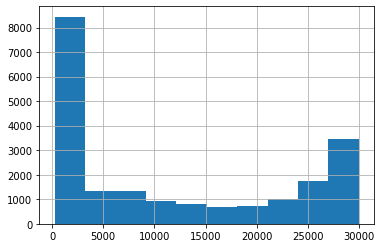

In [26]:
long_labels_df['duration'].hist()

In [27]:
elicitation_wavs = glob('data/elicitation-wavs/wav/*')
elicitation_eafs = glob('data/elicitation-wavs/autotranscribed/*.eaf')

In [28]:
filestem_to_paths = {}
for wav in elicitation_wavs:
    filestem = os.path.splitext(os.path.basename(wav))[0]
    filestem_to_paths[filestem] = {'wav': wav} 


In [29]:
get_wav_with_filestem = lambda fs: filestem_to_paths[fs]['wav']
get_eaf_with_filestem = lambda fs: filestem_to_paths[fs]['eaf']
long_labels_df['wav_source'] = long_labels_df['filestem'].apply(get_wav_with_filestem)

In [30]:
# long_labels_df.to_csv('data/elicitation-wavs/long_labels.csv', index=False)

# Long labels HF dataset
Make a new folder, save `long_labels_df`, snip and move all wavs

In [31]:
'/Users/markjos/projects/malachor5/data/elicitation-wavs/wav'
long_labels_df['wav_source_mac'] = long_labels_df['wav_source'].apply(lambda x: x.replace(
    '/home/AD/mjsimmons/datasets/elicitation-wavs/masked/',
    '/Users/markjos/projects/malachor5/data/elicitation-wavs/wav/'
))
for wav_path in long_labels_df['wav_source_mac'].unique():
    if not os.path.exists(wav_path):
        print(wav_path)

In [32]:
del long_labels_df['wav_source']
long_labels_df = long_labels_df.rename({'wav_source_mac': 'wav_source'}, axis=1)
long_labels_df

,asr_index,start,end,transcription,indices,duration,split,filestem,wav_source
0,11230.0,1229590.0,1259547.0,íŋgánɔ̀nà ɛ́léɲé kə́ náɾùwè nd̪ɔ̀bà T...,"[113180, 69522, 101459, 10, 36988, 69525, 7323...",29957.0,train,HH20220719-2,data/elicitation-wavs/wav/HH20220719-2.wav
1,14569.0,902320.0,930910.0,weird tone patterns. And so that might either ...,"[42, 116519]",28590.0,train,HH20230414-Zoom-3,data/elicitation-wavs/wav/HH20230414-Zoom-3.wav
2,14538.0,1318720.0,1344900.0,"làdɔ́ŋnɛ̀ nìðìnɔ́ŋù ùnɛ̀ɾɛ̀ So actually, ...","[116488, 59]",26180.0,train,HH20220629-2,data/elicitation-wavs/wav/HH20220629-2.wav
3,12250.0,3154322.0,3184300.0,"from the Karcha, Karcha is actually far away. ...","[31526, 72251, 64, 49843, 37711, 19284, 70756,...",29978.0,train,HH20221127,data/elicitation-wavs/wav/HH20221127.wav
4,6154.0,1148379.0,1177450.0,"íŋgáðə́rɔ̀ðà You know, our friend, El Yasse...","[108104, 86, 9008, 63666, 48904]",29071.0,train,HH07242020-Zoom2,data/elicitation-wavs/wav/HH07242020-Zoom2.wav
...,...,...,...,...,...,...,...,...,...
20475,20470.0,1256526.0,1257592.0,ŋàmɽárè,[122420],1066.0,test,HH08212020-2,data/elicitation-wavs/wav/HH08212020-2.wav
20476,20471.0,1261946.0,1262962.0,ŋə̀mìɲàt̪ɔ́ ásá,[122421],1016.0,test,HH20211207-Zoom,data/elicitation-wavs/wav/HH20211207-Zoom.wav
20477,20475.0,1005320.0,1007400.0,ðá nɛ́lê və̀lɛ̀ðɔ́ nd̪ɔ̀bà,[122425],2080.0,train,HH20230516,data/elicitation-wavs/wav/HH20230516.wav
20478,20477.0,1121405.0,1122391.0,ŋə̀búrŋɛ̀ ánó,[122427],986.0,train,HH20230626,data/elicitation-wavs/wav/HH20230626.wav


In [33]:

long_labels_path = 'data/elicitation-wavs/autotranscribed/longlabels.csv'
# long_labels_df.to_csv(long_labels_path, index=False)

In [34]:
long_labels_df = pd.read_csv(long_labels_path)
long_labels_df['transcription'].str.len().describe()

count    20480.000000
mean        97.360791
std         89.925078
min          3.000000
25%         27.000000
50%         55.000000
75%        156.000000
max        540.000000
Name: transcription, dtype: float64

In [35]:
not_eval = long_labels_df['filestem']!='HH20210312'

In [36]:
long_labels_df.columns

Index(['asr_index', 'start', 'end', 'transcription', 'indices', 'duration',
       'split', 'filestem', 'wav_source'],
      dtype='object')

In [37]:
print(f"total\t{(long_labels_df.loc[not_eval,'duration']/3_600_000).sum():.3f} hours")
(long_labels_df.loc[not_eval,'duration']/1_000).describe()

total	67.947 hours


count    20250.000000
mean        12.079518
std         10.931928
min          0.240000
25%          1.959250
50%          7.393000
75%         24.430250
max         29.998000
Name: duration, dtype: float64

In [38]:
asr_df=asr_df.sort_values('asr_index')
asr_df['filestem']=asr_df['eaf_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
long_labels_df=long_labels_df.sort_values('asr_index')

long_labels_df.loc[asr_df['filestem']=='HH20210312', 'start']=asr_df.loc[asr_df['filestem']=='HH20210312', 'start']
long_labels_df.loc[asr_df['filestem']=='HH20210312', 'end']=asr_df.loc[asr_df['filestem']=='HH20210312', 'end']
long_labels_df['duration']=long_labels_df['end']-long_labels_df['start']

is_train = long_labels_df['split']=='train'
print(f"total\t{(long_labels_df.loc[is_train,'duration']/3_600_000).sum():.3f} hours")
(long_labels_df.loc[is_train,'duration']/1_000).describe()

total	51.752 hours


count    16384.000000
mean        11.371341
std         10.710856
min          0.536000
25%          1.950000
50%          6.149500
75%         23.052000
max         29.998000
Name: duration, dtype: float64

In [66]:
print(asr_df.loc[asr_df['split']=='train', 'transcription'].str.split().apply(len).sum())
asr_df.loc[asr_df['split']=='train', 'transcription'].str.split().apply(len).describe()

53923


count    16384.000000
mean         3.291199
std          1.244452
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: transcription, dtype: float64

In [62]:
def add_words_by_lang(s: str, words_by_lang, word_counts_by_lang):
    for w in s.split():
        words_by_lang[get_word_language(w)].add(w)
        word_counts_by_lang[get_word_language(w)]+=1
word_counts_dict ={}
for split in ['train', 'validation', 'test']:
    print(split)
    words_by_lang = {'tira': set(), 'eng': set(), 'misc': set()}
    word_counts_by_lang = {'tira': 0, 'eng': 0, 'misc': 0}
    long_labels_df.loc[long_labels_df['split']==split, 'transcription'].apply(lambda s: add_words_by_lang(s, words_by_lang, word_counts_by_lang))
    word_counts_dict[split]=(word_counts_by_lang, words_by_lang)
    total_words=sum(v for v in word_counts_by_lang.values())
    print(f"tira pct: {word_counts_by_lang['tira']/total_words}")
    print(f"eng pct: {word_counts_by_lang['eng']/total_words}")
    print(f"misc pct: {word_counts_by_lang['misc']/total_words}")

train
tira pct: 0.20980118393966649
eng pct: 0.7374483955096096
misc pct: 0.052750420550723875
validation
tira pct: 0.1478952520802741
eng pct: 0.7918257464512971
misc pct: 0.06027900146842878
test
tira pct: 0.07948278694295167
eng pct: 0.8645014432215521
misc pct: 0.05601576983549621


In [64]:
word_counts_dict['train'][0]

{'tira': 55749, 'eng': 195957, 'misc': 14017}

In [68]:
(55749-54923)/349196

0.0023654337392180896

In [42]:
print(word_counts_by_lang)
words_by_lang['misc']

{'tira': 65179, 'eng': 265150, 'misc': 18867}


{'Chumna.',
 'Durotani',
 'darja',
 'coucou.',
 'Lato,',
 'Valais?',
 'italian',
 'Galando.',
 'kukungapitito.',
 'Kitcheno,',
 'Malden.',
 'Leker',
 'Dhawanaksha',
 'poto,',
 'ngiyol',
 'Ngaal.',
 'karlen',
 'case-mart.com.',
 'Kukulu',
 'vr',
 'Shor.',
 'kota.',
 'Paule',
 "N'kaabh.",
 '98.',
 'Hamid?',
 'Otono.',
 'low-low.',
 'YAML.',
 'ngui',
 'NAPTO,',
 'ezo.',
 'Lali?',
 "n'ele",
 'Lai',
 'Dorna,',
 'Loa',
 'Kupu',
 'P-O-N.',
 'pri...',
 "Kayla's",
 'ver',
 'ngamu',
 'kai',
 'Intira.',
 'Linga,',
 'monto',
 "d'ova",
 'Kamaishi,',
 'Lai?',
 'Arganna.',
 'vala...',
 'Karki',
 'Runlock',
 'kukunga,',
 'not-that-many',
 'au.',
 'Kahino',
 'buddhade.',
 'loado.',
 "po'luli,",
 'Kirlene,',
 'K-O-N.',
 'post-normal',
 'ngau.',
 'chee',
 'toileta',
 'ssawe.',
 'nā',
 'Odenina,',
 "Wendy's.",
 'nyo,',
 'Kakaar,',
 'kāpā',
 'vahara,',
 'Ngave',
 'Sleipnir.',
 'ña,',
 'ZQ.',
 'una.',
 'boli.',
 'kukush',
 'Kiyomo',
 'chafdh',
 'Laori',
 'Ooley,',
 'ndavo.',
 'kongapote,',
 'Kōkongo.',
 'La